## PART A

In [149]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###  Import and analyse the data set.

In [150]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.datasets import imdb

import gensim.downloader as api
import string
from keras.preprocessing import sequence

Hint: - Use `imdb.load_data()` method
- Get train and test set
- Take 10000 most frequent words

In [151]:
most_freq = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=most_freq)

### Perform following data analysis: 
1. Print shape of features and labels 
2. Print value of any one feature and it's label

In [152]:
# Shape of train and test features and target
print('Training feature size',x_train.shape)
print('Training target size',y_train.shape)
print('Testing feature size',x_test.shape)
print('Testing target size',y_test.shape)

Training feature size (25000,)
Training target size (25000,)
Testing feature size (25000,)
Testing target size (25000,)


### Decode the feature value to get original sentence

In [153]:
# Decoding an example of actual review
word_index = imdb.get_word_index()

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [154]:
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in x_train[23]])
print(decoded_review)

? the problems with ? ? ? e ? are many a one line concept that looks good on paper which also worked in an earlier english film love actually goes terribly wrong thanks to inept and shallow writing a well ? idea gets crushed to ? under the weight of its own ? ambition a director so completely ? by his own much ? first film goes overboard with the devices that worked in his earlier film ? ho ? ho try counting the number of times the device of split screens is used in this flick the problem is what worked ? in ? ho ? ho were the emotional ? of the ? ? school of film making but here ? doesn't quite grace us with its appearance on the screen no not even ? the writer director gives us ? relationships with one common problem ? but where is the intensity where is the depth where is the ? a ? to ? sans emotion and one that goes on and on and on ? it just cannot work br br in my opinion the basic ? for a ? film like this to work is that not only should each individual story be ? it should in so

### Design, train, tune and test a sequential model.

In [155]:
#Define maximum number of words to consider in each review
max_review_length = 20 

#### 1. Pad sequences

In [156]:
#Pad training and test reviews
X_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        maxlen=max_review_length,
                                                        padding='pre',
                                                        truncating='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, 
                                                       maxlen=max_review_length, 
                                                       padding='pre',
                                                       truncating='post')

In [157]:
X_train.shape

(25000, 20)

In [158]:
X_test.shape

(25000, 20)

In [159]:
X_train[10]

array([   1,  785,  189,  438,   47,  110,  142,    7,    6, 7475,  120,
          4,  236,  378,    7,  153,   19,   87,  108,  141], dtype=int32)

#### 2. Load Google word2vec model

In [160]:
#Load Google word2vec model
model = api.load('word2vec-google-news-300')

#### 3. Get pre-trained embeddings

In [161]:
embedding_vector_length = model.vector_size

In [162]:
#Initialize embedding matrix for our dataset with 10000+1 rows (1 for padding word)
#and 20 columns (as embedding size is 300)
embedding_matrix = np.zeros((most_freq + 1, embedding_vector_length))

In [163]:
#Load word vectors for each word from Google Word2Vec model
for word, i in sorted(word_index.items(),key=lambda x:x[1]):
    if i > (most_freq+1):
        break
    try:
        embedding_vector = model[word] #Reading word's embedding from Google Word2Vec
        embedding_matrix[i] = embedding_vector
    except:
        pass

#### 4. Build dense model

In [164]:
#Initialize model
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

In [165]:
model.add(tf.keras.layers.Embedding(most_freq + 1, #Vocablury size
                                    embedding_vector_length, #Embedding size
                                    weights=[embedding_matrix], #Embeddings taken from pre-trained model
                                    trainable=False, #As embeddings are already available, we will not train this layer. It will act as lookup layer.
                                    input_length=max_review_length) #Number of words in each review
          )

In [166]:
model.output

<KerasTensor: shape=(None, 20, 300) dtype=float32 (created by layer 'embedding')>

In [167]:
#Flatten the data as we will use Dense layers
model.add(tf.keras.layers.Flatten())

In [168]:
#Add Hidden layers (Dense layers)
model.add(tf.keras.layers.Dense(100, activation='relu', input_shape=()))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(25, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

In [169]:
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [170]:
#Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [171]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 300)           3000300   
                                                                 
 flatten (Flatten)           (None, 6000)              0         
                                                                 
 dense (Dense)               (None, 100)               600100    
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                        

#### 5.Train the model

In [172]:
model.fit(X_train,y_train,
          epochs=20,
          batch_size=32,          
          validation_data=(X_test, y_test))

Epoch 1/20
782/782 [==============================] - 6s 6ms/step - loss: 0.7256 - accuracy: 0.5110 - val_loss: 0.6907 - val_accuracy: 0.5288
Epoch 2/20
782/782 [==============================] - 5s 6ms/step - loss: 0.6864 - accuracy: 0.5450 - val_loss: 0.6837 - val_accuracy: 0.5586
Epoch 3/20
782/782 [==============================] - 5s 6ms/step - loss: 0.6716 - accuracy: 0.5822 - val_loss: 0.6778 - val_accuracy: 0.5712
Epoch 4/20
782/782 [==============================] - 5s 6ms/step - loss: 0.6503 - accuracy: 0.6192 - val_loss: 0.6734 - val_accuracy: 0.5757
Epoch 5/20
782/782 [==============================] - 5s 6ms/step - loss: 0.6242 - accuracy: 0.6516 - val_loss: 0.6792 - val_accuracy: 0.5738
Epoch 6/20
782/782 [==============================] - 5s 6ms/step - loss: 0.5920 - accuracy: 0.6799 - val_loss: 0.6971 - val_accuracy: 0.5726
Epoch 7/20
782/782 [==============================] - 5s 6ms/step - loss: 0.5571 - accuracy: 0.7167 - val_loss: 0.7237 - val_accuracy: 0.5721
Epoch 

#### 6. Build CNN Model

In [173]:
model2 = tf.keras.Sequential()

In [174]:
model2.add(tf.keras.layers.Embedding(most_freq + 1, #Vocablury size
                                    embedding_vector_length, #Embedding size
                                    weights=[embedding_matrix], #Embeddings taken from pre-trained model
                                    trainable=False, #As embeddings are already available, we will not train this layer. It will act as lookup layer.
                                    input_length=max_review_length) #Number of words in each review
          )

In [175]:
model2.output

<KerasTensor: shape=(None, 20, 300) dtype=float32 (created by layer 'embedding_1')>

In [176]:
#Add first convolutional layer
model2.add(tf.keras.layers.Conv1D(64, #Number of filters 
                                 kernel_size=(3), #Size of the filter
                                 strides=1,
                                 activation='relu'))

#normalize data
model2.add(tf.keras.layers.BatchNormalization())

#Add second convolutional layer
model2.add(tf.keras.layers.Conv1D(128, kernel_size=(3), strides=2))
model2.add(tf.keras.layers.ReLU())

#normalize data
model2.add(tf.keras.layers.BatchNormalization())

#Add third convolutional layer
model2.add(tf.keras.layers.Conv1D(128, kernel_size=(3), strides=2))
model2.add(tf.keras.layers.ReLU())

#normalize data
model2.add(tf.keras.layers.BatchNormalization())

In [177]:
#Use Global Average Pooling
model2.add(tf.keras.layers.GlobalAveragePooling1D())

#Output layer
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [178]:
#Compile the model
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [179]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 300)           3000300   
                                                                 
 conv1d (Conv1D)             (None, 18, 64)            57664     
                                                                 
 batch_normalization_1 (Batc  (None, 18, 64)           256       
 hNormalization)                                                 
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 128)            24704     
                                                                 
 re_lu (ReLU)                (None, 8, 128)            0         
                                                                 
 batch_normalization_2 (Batc  (None, 8, 128)           512       
 hNormalization)                                      

#### 7. Train the CNN model

In [180]:
model2.fit(X_train,y_train,
          epochs=20,
          batch_size=32,          
          validation_data=(X_test, y_test))

Epoch 1/20
782/782 [==============================] - 9s 10ms/step - loss: 0.6943 - accuracy: 0.5623 - val_loss: 0.6634 - val_accuracy: 0.5970
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 0.6064 - accuracy: 0.6670 - val_loss: 0.6645 - val_accuracy: 0.6048
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 0.5438 - accuracy: 0.7233 - val_loss: 0.6692 - val_accuracy: 0.6262
Epoch 4/20
782/782 [==============================] - 8s 10ms/step - loss: 0.4658 - accuracy: 0.7768 - val_loss: 0.7465 - val_accuracy: 0.6188
Epoch 5/20
782/782 [==============================] - 8s 10ms/step - loss: 0.3832 - accuracy: 0.8275 - val_loss: 0.8354 - val_accuracy: 0.6186
Epoch 6/20
782/782 [==============================] - 8s 10ms/step - loss: 0.3046 - accuracy: 0.8687 - val_loss: 0.9240 - val_accuracy: 0.6132
Epoch 7/20
782/782 [==============================] - 8s 10ms/step - loss: 0.2379 - accuracy: 0.9032 - val_loss: 1.0546 - val_accuracy: 0.6123

In [181]:
scores_m1 = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores_m1[1] * 100))

Accuracy: 56.20%


In [182]:
scores_m2 = model2.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores_m2[1] * 100))

Accuracy: 61.26%


### Use the designed model to print the prediction on any one sample.

In [183]:
def analyze(text):
    # Prepare the input by removing punctuation characters, converting
    # characters to lower case, and removing words containing numbers
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = text.lower().split(' ')
    text = [word for word in text if word.isalpha()]

    # Generate an input tensor
    input = [1]
    for word in text:
        if word in word_index and word_index[word] < most_freq:
            input.append(word_index[word])
        else:
            input.append(2)
    padded_input = sequence.pad_sequences([input], maxlen=max_review_length)

    # Invoke the model and return the result
    result_m1 = model.predict(np.array([padded_input][0]))[0][0]
    result_m2 = model2.predict(np.array([padded_input][0]))[0][0]

    return result_m1,result_m2

In [184]:
Review1 = 'What a bad movie, hated it'

print('Prediction with Dense Model', analyze(Review1)[0])
print('Prediction with CNN Model', analyze(Review1)[1])

Prediction with Dense Model 0.0046257623
Prediction with CNN Model 0.008412846


In [185]:
Review2 = 'I loved the actors and the amazing direction'

print('Prediction with Dense Model', analyze(Review2)[0])
print('Prediction with CNN Model', analyze(Review2)[1])

Prediction with Dense Model 0.20845927
Prediction with CNN Model 0.6232906


Conclusion : As seen from the two models we can see that
1. Review 1 is a negative sentiment and dense model predicts it with a accuracy of 0.0046 , and CNN model predicts it with a  accuracy of 0.00844 which is closer to 1 ; appropriate for a negative comment

2. Review 2 is a positive sentiment and dense model predicts it with a accuracy of 0.20 , but CNN model predicts it with better accuracy 0.62 which is closer to 1 ; appropriate for a positive comment

## PART B

In [186]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re, string
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix

In [187]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from tensorflow.python.keras.layers import Dropout, Dense, Embedding, Flatten, LSTM
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import Word2Vec, KeyedVectors

### Read and explore the data

In [188]:
#change file path to point to where you have stored the text file.
headlines = pd.read_json('/content/drive/MyDrive/AI-ML/NLP Project/Sarcasm_headlines_dataset.json', lines=True)
headlines.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


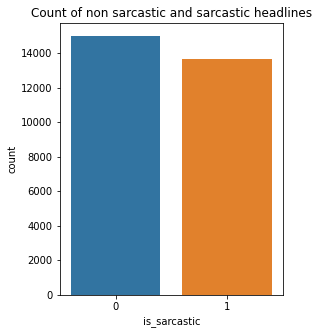

In [189]:
plt.figure(figsize=(4, 5))
sns.countplot(x=headlines['is_sarcastic'])
plt.title('Count of non sarcastic and sarcastic headlines')
plt.show()

*   0 - Sarcastic headline
*   1 - Non-Sarcastic headline

In [190]:
sarcastic = headlines[headlines['is_sarcastic'] == 1]
non_sarcastic = headlines[headlines['is_sarcastic'] != 1]

print('No. of saracastic headlines :', len(sarcastic))
print('No. of non-saracastic headlines :', len(non_sarcastic))

No. of saracastic headlines : 13634
No. of non-saracastic headlines : 14985


In [191]:
def clean_str(string):
  try:   
    # Removing URLs 
    string = re.sub(r'https?:\/\/.*[\r\n]*', '', string) 

    # Removing special characters 
    string = re.sub(r'[\.;:,\?\"\'\/\=\\\-\(\)\*\&\@\$\#\^\%\~\!\+\_\{\}\[\]\|\<\>\`]','', string)

    # Removing only numeric data entries
    string = re.sub(r'[0-9]','',string)  

    # Removing leading and trailing whitespaces
    string = string.strip()

    # Remoing in between whitespaces
    words = string.strip().split()    
    words = [w for w in words if len(w)>=1]
    return " ".join(words)

  except:
    return ""

In [192]:
# apply preprocessing steps

headlines['headline'] = headlines['headline'].str.lower()
headlines['headline'] = headlines['headline'].apply(clean_str)

headlines.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep totally nails why congress is falling ...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word stream...,https://www.theonion.com/mother-comes-pretty-c...


### Retain relevant columns

In [193]:
# Extracting dependent and independent variables
X = headlines['headline']
y = headlines['is_sarcastic']

### Create features and labels

In [194]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

### Get vocabulary size

In [195]:
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train.tolist())

### Get indices for words

In [196]:
X_train = tokenizer.texts_to_sequences(X_train.tolist())
X_test = tokenizer.texts_to_sequences(X_test.tolist())

In [197]:
#Define maximum number of words to consider in each review
max_review_length = 50

In [198]:
#Pad training and test reviews
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        maxlen=max_review_length,
                                                        padding='pre', truncating='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, 
                                                       maxlen=max_review_length, 
                                                       padding='pre', truncating='post')

### Define parameters

In [199]:
#Glove file - we are using model with 50 embedding size
glove_input_file = '/content/drive/MyDrive/AI-ML/NLP Project/DataSet - glove.6B.50d.txt'
#Name for word2vec file
word2vec_output_file = '/content/drive/MyDrive/AI-ML/NLP Project/glove.6B.50d.txt.word2vec'

In [200]:
#Convert Glove embeddings to Word2Vec embeddings
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 50)

In [201]:
# Load pretrained Glove model (in word2vec form)
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [202]:
#Embedding length based on selected model - we are using 50d here.
embedding_vector_length = 50

### Create a weight matrix using GloVe embeddings

In [203]:
#Initialize embedding matrix
embedding_matrix = np.zeros((vocab_size + 1, embedding_vector_length))

In [204]:
embedding_matrix.shape

(10001, 50)

In [205]:
#Initialize embedding matrix
embedding_matrix = np.zeros((vocab_size + 1, embedding_vector_length))

for word, i in sorted(tokenizer.word_index.items(),key=lambda x:x[1]):
    if i > (vocab_size+1):
        break
    try:
        embedding_vector = glove_model[word] #Reading word's embedding from Glove model for a given word
        embedding_matrix[i] = embedding_vector
    except:
        pass

In [206]:
#Word the - index 1
embedding_matrix[3]

array([ 4.18000013e-01,  2.49679998e-01, -4.12420005e-01,  1.21699996e-01,
        3.45270008e-01, -4.44569997e-02, -4.96879995e-01, -1.78619996e-01,
       -6.60229998e-04, -6.56599998e-01,  2.78430015e-01, -1.47670001e-01,
       -5.56770027e-01,  1.46579996e-01, -9.50950012e-03,  1.16579998e-02,
        1.02040000e-01, -1.27920002e-01, -8.44299972e-01, -1.21809997e-01,
       -1.68009996e-02, -3.32789987e-01, -1.55200005e-01, -2.31309995e-01,
       -1.91809997e-01, -1.88230002e+00, -7.67459989e-01,  9.90509987e-02,
       -4.21249986e-01, -1.95260003e-01,  4.00710011e+00, -1.85939997e-01,
       -5.22870004e-01, -3.16810012e-01,  5.92130003e-04,  7.44489999e-03,
        1.77780002e-01, -1.58969998e-01,  1.20409997e-02, -5.42230010e-02,
       -2.98709989e-01, -1.57490000e-01, -3.47579986e-01, -4.56370004e-02,
       -4.42510009e-01,  1.87849998e-01,  2.78489990e-03, -1.84110001e-01,
       -1.15139998e-01, -7.85809994e-01])

### Define and compile a Bidirectional LSTM model.

In [207]:
#Initialize model
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

In [208]:
model.add(tf.keras.layers.Embedding(vocab_size + 1, #Vocablury size
                                    embedding_vector_length, #Embedding size
                                    weights=[embedding_matrix], #Embeddings taken from pre-trained model
                                    trainable=False, #As embeddings are already available, we will not train this layer. It will act as lookup layer.
                                    input_length=max_review_length) #Number of words in each review
          )

In [209]:
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(256)) #RNN State - size of cell state and hidden state
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [210]:
#Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [211]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            500050    
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm (LSTM)                 (None, 256)               314368    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 814,675
Trainable params: 314,625
Non-trainable params: 500,050
_________________________________________________________________


### Fit the model and check the validation accuracy

In [212]:
history = model.fit(X_train,y_train,
                    epochs=10,
                    batch_size=32, 
                    validation_data=(X_test, y_test))  

Epoch 1/10
671/671 [==============================] - 8s 9ms/step - loss: 0.5791 - accuracy: 0.6923 - val_loss: 0.5127 - val_accuracy: 0.7526
Epoch 2/10
671/671 [==============================] - 5s 8ms/step - loss: 0.4710 - accuracy: 0.7767 - val_loss: 0.4270 - val_accuracy: 0.8035
Epoch 3/10
671/671 [==============================] - 5s 8ms/step - loss: 0.4194 - accuracy: 0.8047 - val_loss: 0.4053 - val_accuracy: 0.8137
Epoch 4/10
671/671 [==============================] - 5s 8ms/step - loss: 0.3813 - accuracy: 0.8267 - val_loss: 0.3792 - val_accuracy: 0.8271
Epoch 5/10
671/671 [==============================] - 5s 8ms/step - loss: 0.3541 - accuracy: 0.8414 - val_loss: 0.3644 - val_accuracy: 0.8368
Epoch 6/10
671/671 [==============================] - 5s 8ms/step - loss: 0.3305 - accuracy: 0.8511 - val_loss: 0.3654 - val_accuracy: 0.8382
Epoch 7/10
671/671 [==============================] - 5s 8ms/step - loss: 0.3096 - accuracy: 0.8627 - val_loss: 0.3573 - val_accuracy: 0.8391
Epoch 

In [213]:
model.save('Movie_with_oretrained.h5')

In [214]:
def plot_history(history):
    
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', c='dodgerblue', lw='2')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', c='orange', lw='2')
    plt.title('Accuracy', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', c='dodgerblue', lw='2')
    plt.plot(history.history['val_loss'], label='Validation Loss', c='orange', lw='2')
    plt.title('Loss', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [215]:
def plot_cm(pred):
    
    pred = pred.ravel()
    pred = np.round(pred)
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, cbar=False, fmt='1d', cmap='Blues', ax=ax)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_yticklabels(['Non-Sarcastic', 'Sarcastic', ])
    ax.set_xticklabels(['Non-Sarcastic', 'Sarcastic'])

    plt.show()

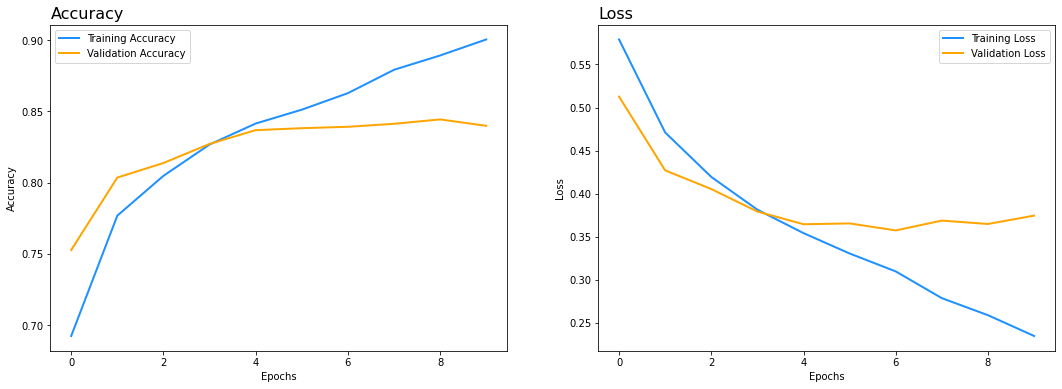

In [216]:
# plot history
plot_history(history)

7/7 [==============================] - 1s 9ms/step


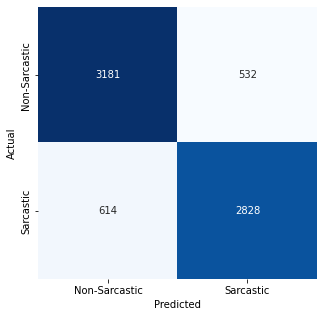

In [217]:
# plot confusion matrix
pred = model.predict(X_test, batch_size = 1024, verbose = 1)
plot_cm(pred)